In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from pathlib import Path

from sklearn import metrics

# Lesson 2

## 00:00:00 - What's coming

* So far all we've learned: there's a thing called Random Forests that works quite well for some datasets.
  * Diving deeper into RFs next.
* After: how do we interpret Random Forests to understand our data?

## 00:00:45 - Review

* Learned about Fast.ai library.
  * Highly opinionated: lots of research for best practises.
* Lots of wrappers on top of existing code.
* Most of today is about getting stuff into and out of Scikit-learn.

## 00:01:44 - Fast.ai library

* Set of notebooks under `fastai/courses/ml1`.
* In that directory, there's a symlink to the parent `fastai` package directory.
* If you want to use Fast.ai library, need to symlink:
  ``ln -s ../fastai fastai``
  
## 00:03:35 - Audience question

* Q1: Do you create symlinks with `ln -s`?
* A1: Yes: `ln -s <source> <dest>`.
  * Similar to shortcut in Windows and alias in Mac.
  
## 00:05:29 - Bluebooks revisited 

* Important to deeply understand evaluation metric for the project.
* In this case it's root mean log squared error: `sqrt(log(acts) - log(preds))**2`

In [2]:
PATH = Path('./data/bluebook/')

In [3]:
df_raw = pd.read_csv(f'{PATH}/Train.csv', low_memory=False, parse_dates=['saledate'])

In [4]:
df_raw.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000,999089,3157,121,3.0,2004,68.0,Low,2006-11-16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000,117657,77,121,3.0,1996,4640.0,Low,2004-03-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000,434808,7009,121,3.0,2001,2838.0,High,2004-02-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500,1026470,332,121,3.0,2001,3486.0,High,2011-05-19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000,1057373,17311,121,3.0,2007,722.0,Medium,2009-07-23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
add_datepart(df_raw, 'saledate')

In [6]:
df_raw.saleYear.head()

0    2006
1    2004
2    2004
3    2011
4    2009
Name: saleYear, dtype: int64

In [7]:
df_raw.SalePrice = np.log(df_raw.SalePrice)

Can use `train_cats` from the Fast.ai library to replace strings with categories.

In [8]:
train_cats(df_raw)

In [9]:
df_raw.UsageBand.cat.categories

Index(['High', 'Low', 'Medium'], dtype='object')

Let's you easily convert categories to codes.

In [10]:
df_raw.UsageBand.cat.codes[:4]

0    1
1    1
2    0
3    0
dtype: int8

`proc_df` will convert categorical columns into codes, convert missing values with the median and add a column that tell you if a value is missing or not.

In [11]:
df, y, na_dict = proc_df(df_raw, 'SalePrice')

In [12]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(df, y)
m.score(df, y)

0.9831486366130021

### 00:10:50 - $r^2$

* $R^2 = 1 - \frac{SS_{res}}{SS_{tot}}$
* Model tells you how much better you are than just predicting the mean.
* Range of values is 1 and below: possible to make a model much worse than the mean.

### 00:17:32 - Measuring overfitting

* With only training performance, you don't know if your model is going to generalise well.

<img src="./images/underfitting-vs-overfitting.png" width=600px>

  * Aka: overfitting
 
* To solve this problem: create a good validation.
* Validation set should be as similiar as possible to validation set.
  * Time series: validation set should be the same time frame as a test set if possible.
  
* In real world: test set should not be looked at while training model. Should only be looked at at the very end of the project.

In [13]:
def split_vals(a, n): return a[:n].copy(), a[n:].copy()

n_valid = 12000
n_trn = len(df) - n_valid
raw_train, raw_valid = split_vals(df_raw, n_trn)
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, X_train.shape, X_valid.shape

((389125, 66), (389125, 66), (12000, 66))

#### 00:23:56 - Audience questions

* Q1: For categorical data, should you convert them into different columns: aka one-hot encoding.
* A1: Will be covered later.

* Q2: Re dividing set into train and validation, why not use pick them randomly?
* A2: Because it is closer to the Kaggle test set: a random validation set would be much easier.

* Q3: If our $r^2$ turns out bad on validation set and we keep trying to improve it, wouldn't we overfit our validation set?
* A3: That's the point of the test set and actually Kaggle has a 4th set to deal with overfitting on the test set.

In [14]:
def rmse(x, y): return math.sqrt(((x-y) ** 2).mean())

m = RandomForestRegressor(n_jobs=-1)
%time m.fit(X_train, y_train)

print(f'RMSE train: {rmse(m.predict(X_train), y_train)}')
print(f'RMSE val: {rmse(m.predict(X_valid), y_valid)}')
print(f'R^2 val: {m.score(X_valid, y_valid)}')

CPU times: user 1min 35s, sys: 1.11 s, total: 1min 36s
Wall time: 33.9 s
RMSE train: 0.0902976506917136
RMSE val: 0.24536677352706274
R^2 val: 0.8924824206064098


## 00:27:08 - Fast.ai style guide (why not use PEP8?)

* Being able to look at something in one go has a lot of value.
* Consistently use certain letters to mean certain things makes sense in data science.
* Should still know and use PEP8 as a software engineer.

## 00:29:28 - Speeding up training and development

* Rule of thumb: if something takes more than 10 secs to run, it's too long to run interactively analysis.
  * Solution: train on a smaller dataset while experimenting.
  * Can pass `subset` param to `proc_df` to reduce the sample size.
  * Want to ensure you resplit your validation set (otherwise it's cheating).

In [30]:
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice', subset=30000)
X_train, _ = split_vals(df_trn, 20000)
y_train, _ = split_vals(y_trn, 20000)

In [16]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(X_train, y_train)

print(f'RMSE train: {rmse(m.predict(X_train), y_train)}')
print(f'RMSE val: {rmse(m.predict(X_valid), y_valid)}')
print(f'R^2 val: {m.score(X_valid, y_valid)}')

CPU times: user 3.5 s, sys: 56.8 ms, total: 3.56 s
Wall time: 1.35 s
RMSE train: 0.1146559987770302
RMSE val: 0.3795391824564153
R^2 val: 0.7427465489478501


## 00:31:50 - Viewing a single tree

* "Forest is made of trees"
* In Scikit-learn, trees are called estimators.

In [23]:
m = RandomForestRegressor(n_estimators=1, max_depth=3, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)

print(f'RMSE val: {rmse(m.predict(X_valid), y_valid)}')
print(f'R^2 val: {m.score(X_valid, y_valid)}')

RMSE val: 0.5826670748205182
R^2 val: 0.3936980994743713


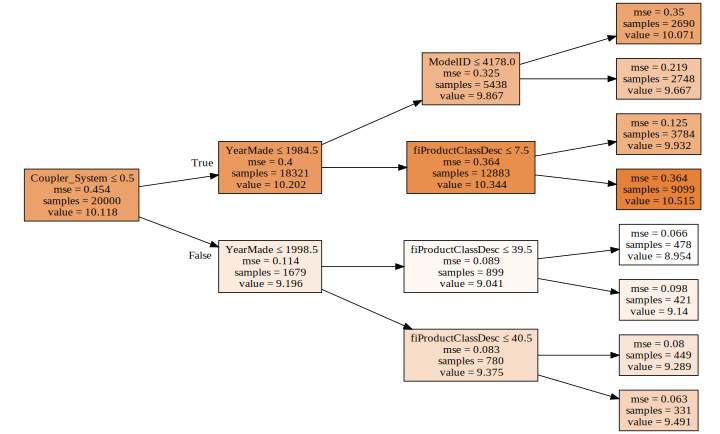

In [24]:
draw_tree(m.estimators_[0], df_trn, precision=3)

* Algorithm has determined that the best split it can make is the `Coupler_System` split at 0.5.
* Uses weighted average of the MSE of the two groups to determine if a split is good or not.
  * Then for the remaining features, it trys to find the next best split.
* Stop when you hit some limit (`max_depth=3`) or when leaf nodes only have 1 thing in them.
  * Can do that by removing the `max_depth` param:

In [25]:
m = RandomForestRegressor(n_estimators=1, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)

RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [28]:
print(f'RMSE train: {m.score(X_train, y_train)}')
print(f'RMSE val: {rmse(m.predict(X_valid), y_valid)}')
print(f'R^2 val: {m.score(X_valid, y_valid)}')

RMSE train: 1.0
RMSE val: 0.46551812634738715
R^2 val: 0.612990909435976


* Which gives us a perfect RMSE value, but obviously overfits a lot (though still performs better than `max_depth`).
* Approach to making trees better: forests.

## 00:47:08 - Bagging

* Forests uses a statistical technique called "bagging".
* Random Forests = "way of bagging trees".
* Bagging:
  * Idea of creating multiple models that are predictive but not correlated with each other.
  * What if you created massive deep trees on only a small subset of the data (similar to the overfit tree above)?
    * That's what a random forest does.
    * All have errors but when averaged they should cancel each other out (in theory).
* By default, `RandomForestRegressor` creates 10 "estimators" (aka random trees).

In [32]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(X_train, y_train)
print(f'R^2 train: {m.score(X_train, y_train)}')
print(f'RMSE val: {rmse(m.predict(X_valid), y_valid)}')
print(f'R^2 val: {m.score(X_valid, y_valid)}')

R^2 train: 0.9721396726011831
RMSE val: 0.3402005833666654
R^2 val: 0.7933106583334829


### 00:51:27 - Audience questions

* Q1: Are we taking 10 crappy models on random subsets and combining them to create a good model?
* A1: Yes.

* Q2: Is there a certain number of trees you need to get a good RMSE?
* A2: Will look at hyperparameters soon.

* Q3: Can subsets have overlap?
* A3: Scikit-learn, picks out n rows with "replacement", which means that on average 63.2% of rows are represented.

* Q4: Is a tree simply finding points most like your current point?
* A4: Yes, but you're trying to find a model which tells you which variables are important and how they work together.